In [80]:
%matplotlib inline

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from matplotlib import colors

import os
import random
import pickle
import math

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint

print "using ordering:", K.image_dim_ordering()

using ordering: tf


In [81]:
# load image for prediction

imageFolder = "--images"

image_dim = 1

fac = 4 ### PARAMETER 1 - REDUCES THE RESOLUTION OF THE AERIAL IMAGE 
        ### *THIS SHOULD MATCH WHAT YOU USED IN TRAINING

for fileName in ["Dubai_2016_x.jpg"]:
    img = misc.imread("/".join([imageFolder, fileName]))

    if image_dim == 1 and len(img.shape) > 2: 
        img = img[:,:,0]
    
    img = misc.imresize(img, (img.shape[0]/fac, img.shape[1]/fac), interp='nearest')
    img = img / 255.0

print "Load data complete"

Load data complete


image dimensions: (306, 546)


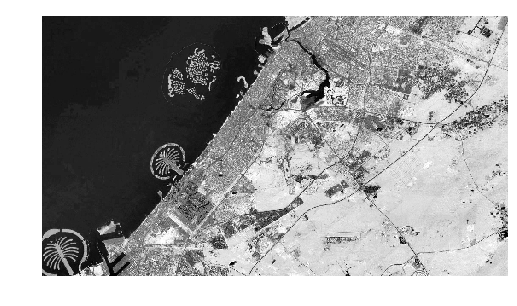

In [82]:
# preview image

print "image dimensions:", img.shape

imshow(img, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 1,  interpolation='nearest')
plt.axis('off')
plt.show()

In [83]:
# generate samples from image

targetRes = 32  ### PARAMETER 2 - CONTROLS THE SIZE OF THE TRAINING IMAGES 
                ### *THIS SHOULD MATCH WHAT YOU USED IN TRAINING
    
stride = 1      ### PARAMETER 3 - CONTROLS THE NUMBER OF SAMPLES PRODUCED 
                ### *THIS DOES NOT HAVE TO MATCH WHAT YOU USED IN TRAINING
                ### *FOR EXAMPLE, YOU CAN TRAIN ON A SMALLER SUBSET OF SAMPLES, 
                ### *BUT THEN PREDICT ON ALL SAMPLES AS SHOWN HERE

xStep = int( math.floor( ( float(img.shape[0]) - targetRes ) / stride) )
yStep = int( math.floor( ( float(img.shape[1]) - targetRes ) / stride) )

print xStep, yStep

data = []

for y in range(yStep):
    for x in range(xStep):
        crop = img[x * stride : (x * stride) + targetRes, y * stride : (y * stride) + targetRes]
        data.append(crop)
        
print "num samples:", len(data)

274 514
num samples: 140836


In [84]:
# specify input shape and number of classes for model

if K.image_dim_ordering() == 'th':
    input_shape = (1, targetRes, targetRes)
else:
    input_shape = (targetRes, targetRes, 1)

num_classes = 4

In [85]:
# model hyperparameters
batch_size = 32
nb_epoch = 15

# network architecture
patch_size_1 = 3
patch_size_2 = 3
patch_size_3 = 3

depth_1 = 32
depth_2 = 64
depth_3 = 128

pool_size = 2

num_hidden_1 = 512
num_hidden_2 = 512

dropout = 0.25

In [86]:
model = Sequential()

model.add(Convolution2D(depth_1, patch_size_1, patch_size_1,
                        border_mode='valid',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(depth_2, patch_size_2, patch_size_2,
                        border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Convolution2D(depth_3, patch_size_3, patch_size_3,
                        border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

model.add(Flatten())

model.add(Dense(num_hidden_1))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(num_hidden_2))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(num_classes))

model.add(Activation('softmax'))


In [87]:
# laod model from saved file

model.load_weights("-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [88]:
# build X dataset for prediction
# for memory management, we need to break up the dataset into batches, 
# run the predictions on each batch, and then recompile all predictions
# this will take some time!

max_batch_size = 10000
num_batches = int( math.ceil( len(data) / float(max_batch_size) ) )

print num_batches

pred = []

for batch in range(num_batches):
# for batch in [0]:
    batch_size = min( max_batch_size, len(data) - (batch * max_batch_size) )
    X = np.ndarray(( batch_size, targetRes, targetRes), dtype=np.float32)
    start_point = batch * max_batch_size
    
    for i, d in enumerate(data[ start_point : start_point + batch_size ]):
        X[i] = d
    
    if K.image_dim_ordering() == 'th':
        X = X.reshape(X.shape[0], 1, targetRes, targetRes)
    else:
        X = X.reshape(X.shape[0], targetRes, targetRes, 1)
    
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html
    pred += np.argmax(model.predict(X), axis=1).tolist()

15


In [89]:
# create new image as numpy array, and build up image from predicted values
# here we are using the same nested loop that we used to generate samples 
# to reformat the list of predictions as a 2-d image

pred_img = np.ndarray(( xStep, yStep), dtype=np.int32)

count = 0

for y in range(yStep):
    for x in range(xStep):
        pred_img[x, y] = pred[count]
        count += 1

(-0.5, 513.5, 273.5, -0.5)

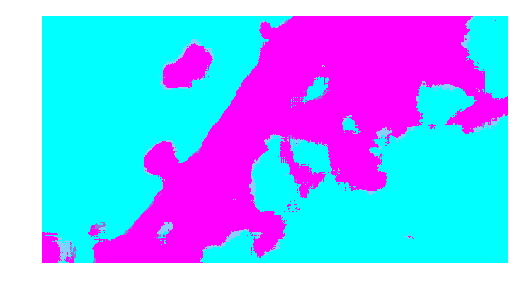

In [90]:
# plot image using 4 color values for the 4 categories

cmap = colors.ListedColormap(['cyan', 'lightskyblue', 'mediumpurple', "fuchsia"])
imshow(pred_img,interpolation='nearest',cmap=cmap)
plt.axis('off')